In [2]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above. 
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

OS information
Linux-5.3.0-45-generic-x86_64-with-Ubuntu-16.04-xenial

Is GPU available?
True

GPU information
Thu Apr  9 14:28:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
| 26%   50C    P2    71W / 270W |   1163MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                             

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET
Files already downloaded and verified


In [5]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [6]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

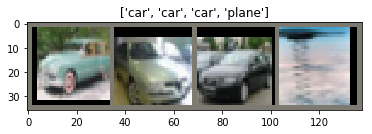

In [10]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

#############
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        #convolution layer이다.
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            #32x32x3 => 32X32X64
        
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            #32x32x64 => 32X32X64
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64 ,128, 3, padding=1),  nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            #16x16x64 => 16X16X128
            nn.Conv2d(128, 128, 3, padding=1),  nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            #16x16x128 => 16X16X128
            nn.MaxPool2d(2, 2),
            
            
            nn.Conv2d(128 ,256, 3, padding=1),  nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            #8x8x128 => 8X8X256
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            #8x8x256 => 8X8X256
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            #8x8x256 => 8X8X256
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256 ,512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            #4x4x256 => 4X4X512
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            #4x4x512 => 4X4X512
            nn.Conv2d(512, 512, 3, padding=1),  nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            #4x4x512 => 4X4X512
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512 ,512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            #2x2x512 => 2X2X512
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            #2x2x512 => 2X2X512
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512),
            #2x2x512 => 2X2X512
            nn.MaxPool2d(2, 2),
        )
        #fc layer이다.
        self.fc = nn.Sequential(
            nn.Linear(512, 4096), nn.ReLU(0.2),
            nn.Linear(4096, 4096), nn.ReLU(0.2),
            nn.Linear(4096, 3)
                               )
     
        
    def forward(self, x):
        
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
            
            
        
#############



STEP 3: CREATE MODEL CLASS (VGG16)


In [12]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  33620035


VGG(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [13]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


In [14]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20
from tqdm.notebook import tqdm

iter = 0
#############
for epoch in range(num_epochs):
    for i, (img, labels) in enumerate(tqdm(train_loader)):
        img = img.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(img)   
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        iter += 1
        
        if iter % 118 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for img, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                img = img.to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(img)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            
#############



STEP 7: TRAIN THE MODEL


Iteration: 118. Loss: 0.6481942534446716. Accuracy: 80.56666666666666



Iteration: 236. Loss: 0.3322696387767792. Accuracy: 86.9



Iteration: 354. Loss: 0.3653741776943207. Accuracy: 88.83333333333333



Iteration: 472. Loss: 0.28257444500923157. Accuracy: 90.6



Iteration: 590. Loss: 0.23382709920406342. Accuracy: 91.0



Iteration: 708. Loss: 0.23709805309772491. Accuracy: 90.83333333333333



Iteration: 826. Loss: 0.36641326546669006. Accuracy: 91.63333333333334



Iteration: 944. Loss: 0.14499293267726898. Accuracy: 91.53333333333333



Iteration: 1062. Loss: 0.1331699937582016. Accuracy: 91.96666666666667



Iteration: 1180. Loss: 0.02887299656867981. Accuracy: 92.43333333333334



Iteration: 1298. Loss: 0.2332521229982376. Accuracy: 93.13333333333334



Iteration: 1416. Loss: 0.01026617456227541. Accuracy: 93.0



Iteration: 1534. Loss: 0.030825862661004066. Accuracy: 93.0



Iteration: 1652. Loss: 0.021432986482977867. Accuracy: 93.3



Iteration: 1770. Loss: 0.0024006664752960205. Accuracy: 92.96666666666667



Iteration: 1888. Loss: 0.00446850061416626. Accuracy: 92.86666666666666



Iteration: 2006. Loss: 0.36032700538635254. Accuracy: 93.3



Iteration: 2124. Loss: 0.03244127705693245. Accuracy: 93.5



Iteration: 2242. Loss: 0.0017271339893341064. Accuracy: 91.26666666666667



Iteration: 2360. Loss: 0.003469486953690648. Accuracy: 91.9



In [8]:
import torch.nn as nn

In [9]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')
#############
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        # 전체 frame
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.conv2 = self._add_layer_(3, 64, 256, 1)
        self.conv3 = self._add_layer_(4, 256, 512, 2)
        self.conv4 = self._add_layer_(6, 512, 1024, 2)
        self.conv5 = self._add_layer_(3, 1024, 2048, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc1 = nn.Linear(2048, 3)
        
    # argement들을 받아서 bottleneck layer를 그에 맞게 만들어 주는 layer이다.
    def _add_layer_(self, num_layer, in_channel, out_channel, strides):
        layer = []
        for i in range(num_layer-1):
            # 각각의layer set의 첫번째 bottleneck layer는 input channel 과 output channel이 다르므로 Ekfh 선언해주었다.
            # 마지막 bottleneck layer 또한 receptive field가 줄어드므로 stride를 argument에 맞게 입력해준다.
            # 그 이외의 경우는 모든게 사실상 기본 setting이다.
            # append()를 이용하여 입력되는 argument에 따라 layer를 확장시켜주었다.
            if i == 0:
                layer.append(BottleNeck(in_channel, out_channel, int(1), True))
            if i == num_layer-2:
                layer.append(BottleNeck(out_channel, out_channel, strides, False))
            else:
                layer.append(BottleNeck(out_channel,out_channel, int(1), False))
            
        return nn.Sequential(*layer)
           
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        
        x = x.view(x.size(0),-1)
        x = self.fc1(x)

        
        return x
        
                
        
        
class BottleNeck(nn.Module): # bottleneck module
    def __init__(self, in_channel, out_channel, strides, downsample = False):
        super(BottleNeck, self).__init__()
        self.dw = downsample
        #input , 중간  output(middle), output channel의 사이즈를 혹시 몰라서 int로 다시 선언
        middle_channel = int(out_channel/4)
        out_channel = int(out_channel)
        in_channel = int(in_channel)
        #bottleneck layer이다.
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, middle_channel, 1),
            nn.BatchNorm2d(middle_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channel, middle_channel, 3,padding=1),
            nn.BatchNorm2d(middle_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channel, out_channel, 1,stride=strides),
            nn.BatchNorm2d(out_channel),
        )
        # stride가 1이거나 처음 입력된 channel의 사이즈가  output channel사이즈랑 다를 경우 channel expand를 하거나 size를 줄여준다. 아무 경우도 해당하지 않을 경우 빈 layer로 선언한다.
        self.downsample = nn.Sequential()
        if in_channel != out_channel or strides != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, stride=strides),
                nn.BatchNorm2d(out_channel)
            )
        self.relu = nn.ReLU(inplace=True)
        
        #bottleneck layer에서 한번의 연산이 이루어 지고 그 결과 값을 반환하도록 하였다.

    def forward(self, x):
        #skip connection을 위해 input을 item에 저장이후 downsample layer를 통과시킨 이후 다시 더해준다.
        item = x
        
        x = self.conv(x)

        
        item = self.downsample(item)
        x += item
        x = self.relu(x)
        
        return x
        
                
            
        

#############

    



STEP 3: CREATE MODEL CLASS (ResNet-50)


In [10]:
print('STEP 4: INSTANTIATE MODEL CLASS')
#############
model = ResNet50()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.cuda()
#############

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  29048835


ResNet50(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): BottleNeck(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentu

In [ ]:



print('STEP 5: INSTANTIATE LOSS CLASS')
#############
criterion = nn.CrossEntropyLoss().to(device)
#############

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
#############
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)#############

print('STEP 7: TRAIN THE MODEL')
num_epochs = 15

iter = 0
#############
for epoch in range(num_epochs):
    for i, (img, labels) in enumerate(train_loader):
        img = img.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(img)   
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        iter += 1
        
        if iter % 118 == 0:
            class_correct = list(0. for i in range(10))
            class_total = list(0. for i in range(10))

            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    images = images.cuda()
                    labels = labels.cuda()
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1) # prediction
                    c = (predicted == labels).squeeze()
                    for i in range(4):
                        label = labels[i]
                        class_correct[label] += c[i].item()
                        class_total[label] += 1
            cl = 0
            cl_t = 0
            for i in range(3):
                print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))
                cl += int(class_correct[i])
                cl_t += int(class_total[i])
            
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(),100 * cl / cl_t))
            


STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Accuracy of plane : 56 %
Accuracy of   car : 77 %
Accuracy of  bird : 86 %
Iteration: 118. Loss: 0.9795852303504944. Accuracy: 74.16666666666667
Accuracy of plane : 64 %
Accuracy of   car : 82 %
Accuracy of  bird : 88 %
Iteration: 236. Loss: 0.6023942828178406. Accuracy: 79.16666666666667
Accuracy of plane : 67 %
Accuracy of   car : 77 %
Accuracy of  bird : 83 %
Iteration: 354. Loss: 0.40906834602355957. Accuracy: 76.66666666666667
Accuracy of plane : 64 %
Accuracy of   car : 85 %
Accuracy of  bird : 88 %
Iteration: 472. Loss: 0.6208081841468811. Accuracy: 80.0
Accuracy of plane : 62 %
Accuracy of   car : 92 %
Accuracy of  bird : 90 %
Iteration: 590. Loss: 0.2486552745103836. Accuracy: 82.5
Accuracy of plane : 72 %
Accuracy of   car : 75 %
Accuracy of  bird : 86 %
Iteration: 708. Loss: 0.6412670016288757. Accuracy: 78.33333333333333
Accuracy of plane : 81 %
Accuracy of   car : 95 %
Accuracy of  b

### Discusion
> Vgg16 Network는 매우 단순한 Network 구조를 가지므로 구현하는 부분에 있어서는 어려움이 없었다. 그리고 보여줬던 특징으로는 다음과 같다.
>> 1) fc layer에서 parameter수가 갑작스럽게 증가하는 것을 확인할 수 있었습니다.
>> 2) 그럼에도 불구하고 예전 모델이다보니 parameter 수가 layer에 비해 많기는 하지만 절대적으로는 큰 수치가 아니어서 training 속도가 빠른 것을 확인할 수 있었습니다. tqdm module을 이용하여 1080ti 상에서 test 해본 결과 속도가 4초와 1분 5초로 vgg16이 더 빠르고 또한 수렴속도가 빠른 것을 확인할 수 있다. 그 이유중 또 다른 이유로 생각되는 부분이 parameter수 차이도 있지만 module 을 하나 더 선언하여 module을 불러오는 시간때문에 더 길어진 것 같다.

>> <resnet50> <img src="https://drive.google.com/uc?id=1n9gcdtCJuFfY99EuP1JHV0Hhsl3MGfMd" alt="no_image" width="500" height="700"/> </resnet50>
>> <vgg16> <img src="https://drive.google.com/uc?id=1Ozpqyh4KeTr6VzqJa3AS1yqEA0bEbW1B" alt="no_image" width="500" height="200"/> </vgg16>


> ResNet50
>> ResNet50을 구현하기 위해 논문의 내용도 내용이지만 Bottleneck layer를 구현하기 위해서 많은 고민을 하였다.  한 모듈 안에서 단순하게 작성하지 않은 가장 큰 이유로는 skip connection을 활성화 하는 것을 하기 위해서는
forward 함수에 각 bottleneck layer에 stride, input channel과 output channel을 전달해야 했으며 이럴 경우 모든 bottleneck layer의 arguments들을 새롭게 assign해주어야 한다는 문제점이 있었기 때문이다.

>> 이를 해결하기 위해 torchvision에 내장되어 있는 resnet module을 참고하고 작성하였다. 차이점은 다음과 같다. 
>>> - downsample을 argument로 받지 않고 stride가 1이 아니거나 input channel과 output channel이 다를경우 1x1 convolution을 진행하였다. (channel expand, strided convolution)
>>> - 각 conv layer마다 첫 번째 bottleneck layer에서만 residue에 대하여 channel expand를 하므로 단순하게 그 부분에서만 channel expand 하도록 코드 작성을 하였다.

>> 이후 성능 향상을 위해 ReLU의 기울기 값이랑 Receptive field 를 줄여주는 layer의 위치를 바꾸는 것을 해보았다.
>>> - default(=1), 0.4, 0,2 에서 진행해보았으나 default에서 가장 좋은 성능을 보여주었다.
>>> - Receptive field 조절을 위한 conv layer 찾기에서는 - 첫 번째, 세 번째 1x1 conv layer에 적용시 testing accuracy가 82% 근방에서 수렴하는 것을 확인할 수 있었다. 이후 3x3 conv layer에서 적용시 성능이 87까지 올라가는 것을 확인하고 고정하고 실행하였다.

>> parameter 수가 reference의 ResNet50에 비해서 높게 나왔다. Reference는 23mil이었고 코드 구현 시 나오는 수는 29mil이었다. 이유로는 다음과 같다고 생각한다.
>>> - 대부분의 network는 channel의 dimension을 크게 변화 없이 가져가는데 해당 network에서는 32 > 64 > ... > 2048등 계속 증가하여 여기서 parameter수가 증가하지 않았나 싶다.



>> <resnet50-on> <img src="https://drive.google.com/uc?id=14yDtcvmCWr0NT8G77obr9vvk4-wL5clU" alt="no_image" width="500" height="700"/> </resnet50-on>
